# hpstr:ptrless
Using `hpstr:ptrless` to create tuples that can be loaded by `uproot` and `awkward`.

In [1]:
import uproot
import awkward as ak
import numpy as np

import coffea
import coffea.nanoevents

import hist
import matplotlib.pyplot as plt
import matplotlib
import mplhep
%matplotlib inline
matplotlib.style.use(mplhep.style.ROOT)

from pyidm import roast

In [10]:
vtx = {
    'signal' : roast.vertices('/local/cms/user/eichl008/hps/idm/signal/idm_2pt3_mchi_030_rmap_3.00_rdmchi_0.60_nruns_200_nevents_10k.root'),
    'wab': roast.vertices('/data/cmszfs1/user/eichl008/hps/idm/bkgd/wab/tuples/wab-beam_nruns_2000_startrun_1.root'),
    'tritrig': roast.vertices('/data/cmszfs1/user/eichl008/hps/idm/bkgd/tritrig/tuples/tritrig-beam_nruns_200_startrun_1.root')
}

/export/scratch/users/eichl008/hps/idm/reach/2016/venv/lib64/python3.6/site-packages/coffea/nanoevents/mapping/uproot.py:102: UserWarning: Skipping UnconstrainedV0Vertices_KF/UnconstrainedV0Vertices_KF.electron_.track_.tracker_hits_ as it is not interpretable by Uproot
  warnings.warn(f"Skipping {key} as it is not interpretable by Uproot")
/export/scratch/users/eichl008/hps/idm/reach/2016/venv/lib64/python3.6/site-packages/coffea/nanoevents/mapping/uproot.py:102: UserWarning: Skipping UnconstrainedV0Vertices_KF/UnconstrainedV0Vertices_KF.electron_.track_.particle_ as it is not interpretable by Uproot
  warnings.warn(f"Skipping {key} as it is not interpretable by Uproot")
/export/scratch/users/eichl008/hps/idm/reach/2016/venv/lib64/python3.6/site-packages/coffea/nanoevents/mapping/uproot.py:102: UserWarning: Skipping UnconstrainedV0Vertices_KF/UnconstrainedV0Vertices_KF.electron_.track_.cov_ as it is not interpretable by Uproot
  warnings.warn(f"Skipping {key} as it is not interpretable

In [11]:
signal_reco = roast.from_root('/local/cms/user/eichl008/hps/idm/signal/idm_2pt3_mchi_030_rmap_3.00_rdmchi_0.60_nruns_200_nevents_10k.root')

In [12]:
signal_particles_pass_reco = roast.mc_particles(signal_reco)

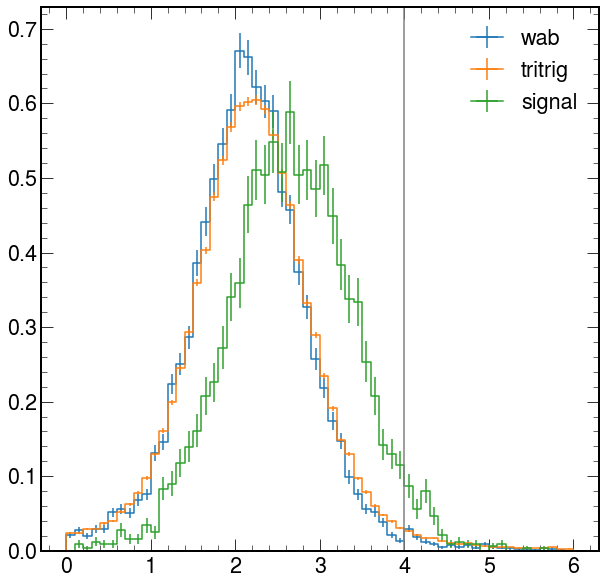

In [13]:
tdiff = hist.Hist(
    hist.axis.StrCategory(
        ['wab','tritrig','signal'],
        name='type'
    ),
    hist.axis.Regular(
        60,0,6,
        name = 'tdiff',
        label = '$e^-$ Track-Cluster $\Delta t$ [ns]'
    )
)
for t, v in vtx.items():
    tdiff.fill(
        type = t,
        tdiff = abs(v.electron.track.time - v.electron.cluster.time + 43.0),
    )
tdiff.plot(density = True)
plt.axvline(4, color='gray')
plt.legend()
plt.show()

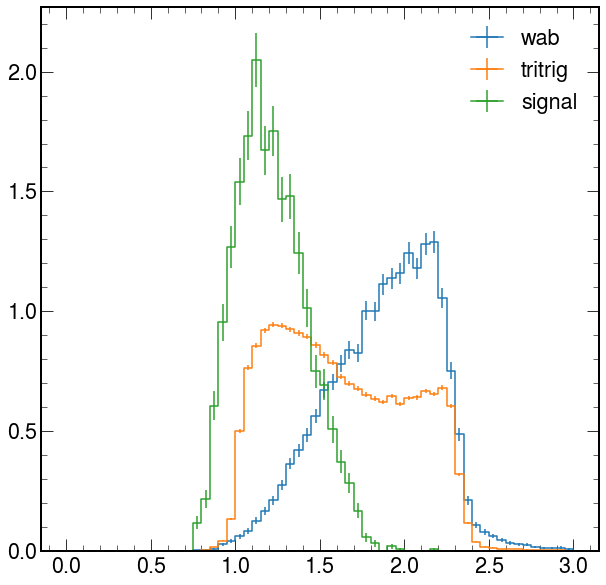

In [14]:
psum = hist.Hist(
    hist.axis.StrCategory(
        ['wab','tritrig','signal'],
        name='type'
    ),
    hist.axis.Regular(
        60,0,3,
        name = 'psmu',
        label = '$P(e^-)+P(e^+)$ [GeV]'
    )
)
for t, v in vtx.items():
    psum.fill(t, v.electron.track.p.mag + v.positron.track.p.mag)
psum.plot(density = True)
plt.legend()
plt.show()

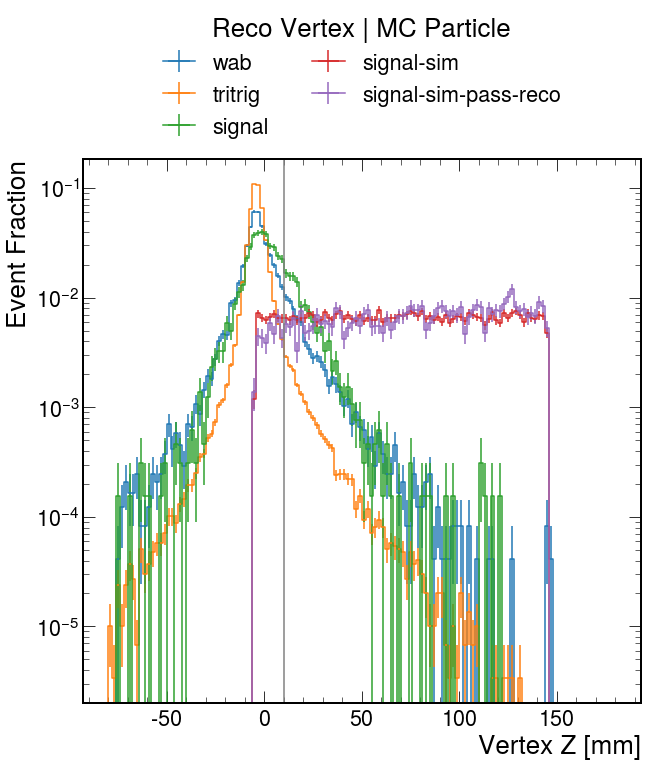

In [17]:
vtxz = hist.Hist(
    hist.axis.StrCategory(
        ['wab','tritrig','signal','signal-sim','signal-sim-pass-reco'],
        name='type'
    ),
    hist.axis.Regular(
        130,-80,180,
        name = 'vtxz',
        label = 'Vertex Z [mm]'
    )
)
for t, v in vtx.items():
    vtxz.fill(
        type = t,
        vtxz = v.pos.fZ,
    )
vtxz.fill(
    type = 'signal-sim',
    vtxz = chi2.ep.z
)
vtxz.fill(
    type = 'signal-sim-pass-reco',
    vtxz = ak.flatten(
        signal_particles_pass_reco[
            (signal_particles_pass_reco.pdg == 1000023)&(ak.count(
                signal_reco['UnconstrainedV0Vertices_KF/UnconstrainedV0Vertices_KF.fUniqueID'],
                axis=1
            )==1)
        ].ep.z)
)
vtxz.plot(density = True)
plt.yscale('log')
plt.xlabel('Vertex Z [mm]')
plt.ylabel('Event Fraction')
plt.legend(
    title = 'Reco Vertex | MC Particle',
    ncol = 2,
    loc = 'lower center',
    bbox_to_anchor=(0.5,1)
)
plt.axvline(10, color='gray')
plt.show()

In [18]:
simz = ak.flatten(signal_particles_pass_reco[
    (signal_particles_pass_reco.pdg == 1000023)
    &(ak.count(
        signal_reco['UnconstrainedV0Vertices_KF/UnconstrainedV0Vertices_KF.fUniqueID'], 
        axis=1
    )==1)
].ep.z)

In [19]:
simz

<Array [111, 49.1, 117, ... 136, 129, 129] type='3232 * float64[parameters={"__d...'>

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7fbb2925d860>, cbar=<matplotlib.colorbar.Colorbar object at 0x7fbb292db358>)

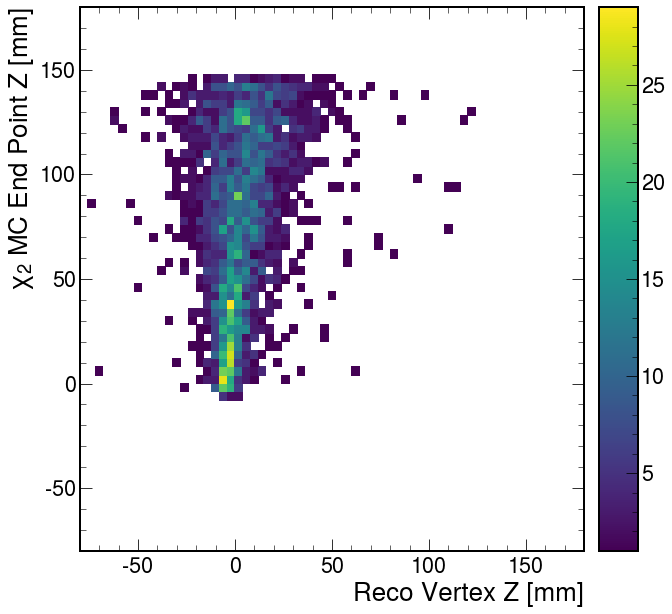

In [20]:
hist.Hist(
    hist.axis.Regular(
        65,-80,180,
        name = 'reco',
        label = 'Reco Vertex Z [mm]'
    ),
    hist.axis.Regular(
        65,-80,180,
        name = 'sim',
        label = '$\\chi_2$ MC End Point Z [mm]'
    )
).fill(
    reco = vtx['signal'].pos.fZ,
    sim = simz
).plot(
    cmin = 1
)

In [2]:
sim = roast.from_root('/local/cms/user/eichl008/hps/idm/signal/sim_idm_2pt3_mchi_030_rmap_3.00_rdmchi_0.60_nruns_1_nevents_10k.root')

In [4]:
particles = roast.mc_particles(sim)
ecal_hits = roast.mc_ecal_hits(sim)
tracker_hits = roast.mc_tracker_hits(sim)

In [5]:
ak.count(ecal_hits.x, axis=1)

<Array [9, 1, 1, 2, 7, 1, ... 7, 0, 2, 4, 0, 0] type='10000 * int64'>

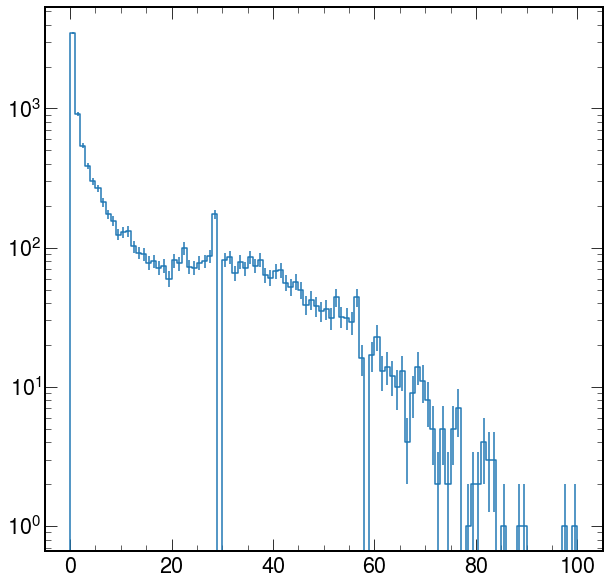

In [6]:
nhits = hist.Hist(
    hist.axis.Regular(
        start=0, stop=100, bins=100, 
        flow=True,
        name='nhits',
        label='Num Ecal Sim Hits'
    )
).fill(
    ak.count(ecal_hits.x, axis=1)
)
nhits.plot()
#plt.xscale('log')
plt.yscale('log')

In [7]:
hit_loc = hist.Hist(
    hist.axis.Regular(51,-25.5,25.5,name='ix',label='iX'),
    hist.axis.Regular(13,-6.5,6.5,name='iy',label='iY'),
).fill(
    ix = ak.flatten(ecal_hits.ix),
    iy = ak.flatten(ecal_hits.iy)
)

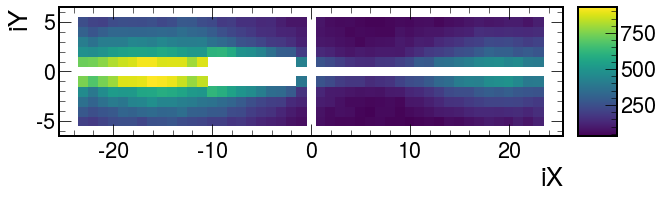

In [8]:
hit_loc.plot(
    cmin=1,
    #norm='log'
)
plt.gca().set_aspect('equal')

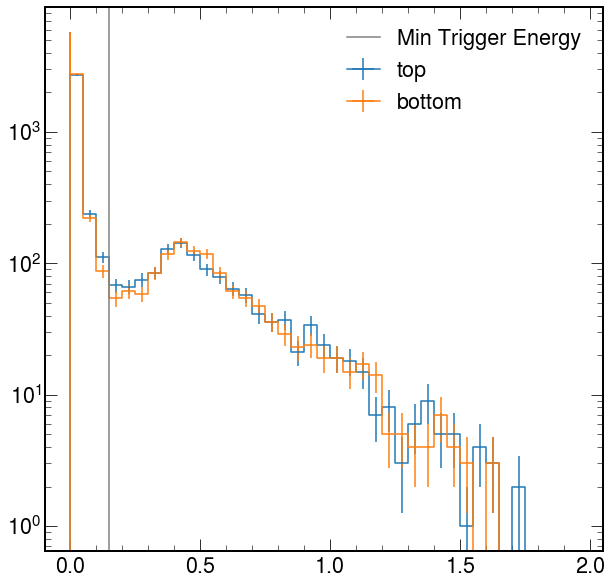

In [33]:
sim_trigger = hist.Hist(
    hist.axis.StrCategory(
        ['top','bottom'],
        name='half',
        label='Half'
    ),
    hist.axis.Variable(
        np.concatenate(([0,1e-3],np.arange(0.05,2,0.05))),
        name='tot_sim_energy',
        label='Total Sim Energy [?GeV?]'
    )
)
sim_trigger.fill(
    half='top',
    tot_sim_energy = ak.sum(ecal_hits.energy[ecal_hits.iy > 0], axis=1)
)
sim_trigger.fill(
    half='bottom',
    tot_sim_energy = ak.sum(ecal_hits.energy[ecal_hits.iy < 0], axis=1)
)
sim_trigger.plot()
plt.axvline(0.15, label='Min Trigger Energy',color='gray')
plt.legend()
plt.yscale('log')
plt.show()

In [16]:
chi2 = ak.flatten(particles[particles.pdg==1000023])

[StepArtists(step=<matplotlib.lines.Line2D object at 0x7f2b17f4af28>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

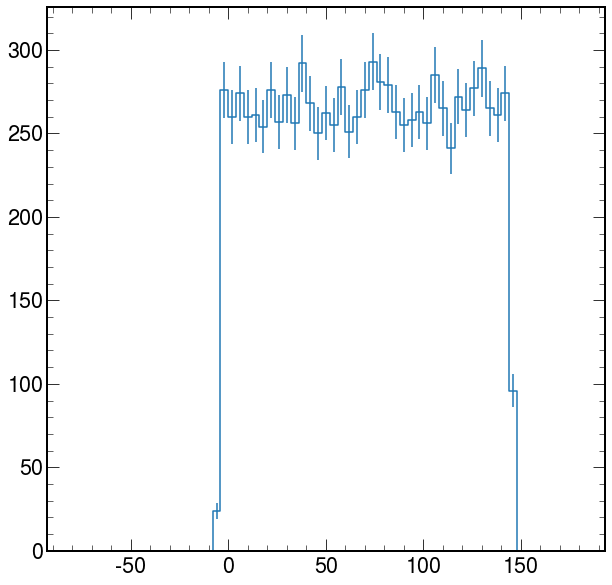

In [48]:
hist.Hist(
    hist.axis.Regular(
        65,-80,180,
        name = 'vtxz',
        label = 'Vertex Z [mm]'
    )
).fill(chi2.ep.z).plot()

In [58]:
nhits = hist.Hist(
    hist.axis.Regular(
        65,-80,180,
        name='vtxz',
        label='Vertex Z [mm]'
    ),
    hist.axis.Regular(
        start=0, stop=100, bins=100, 
        flow=True,
        name='nhits',
        label='Num Ecal Sim Hits'
    ),
    hist.axis.Regular(
        20,0,2,
        name='ecal_sim_energy',
        label='Sim ECal Energy [GeV]'
    ),
).fill(
    vtxz = chi2.ep.z,
    nhits = ak.count(ecal_hits.x, axis=1),
    ecal_sim_energy = ak.sum(ecal_hits.energy, axis=1),
)

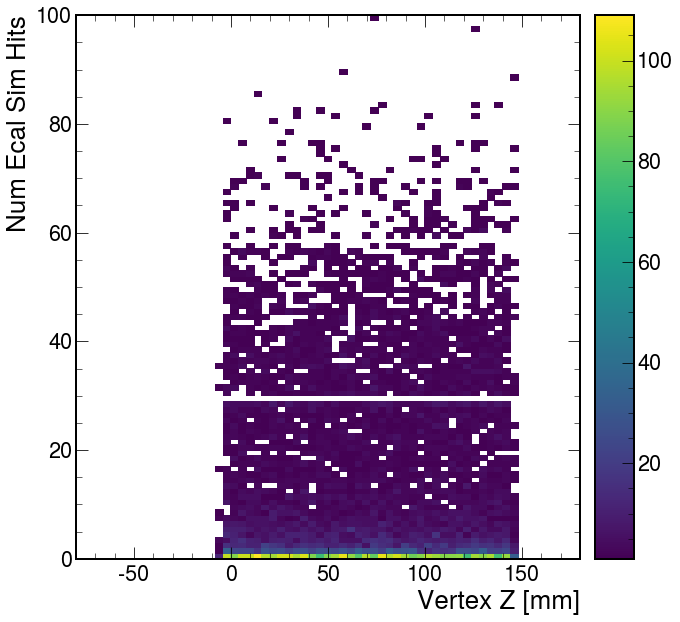

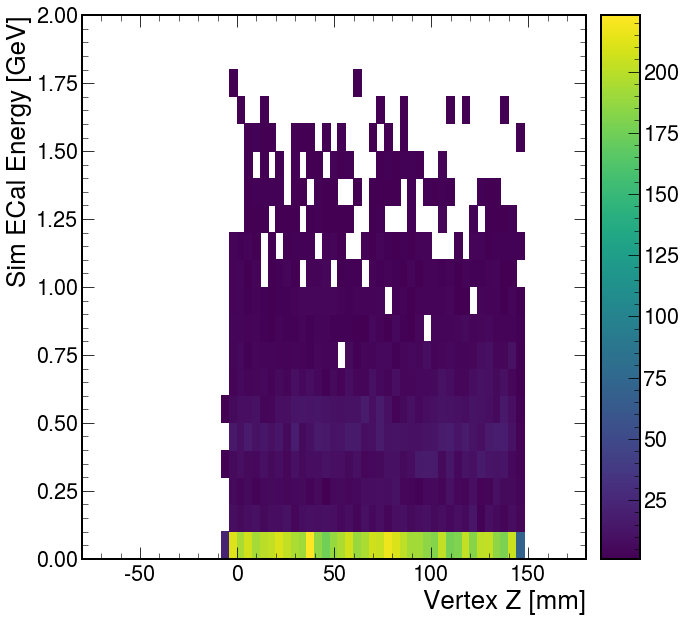

In [61]:
nhits[:,:,sum].plot(cmin = 1)
plt.show()
nhits[:,sum,:].plot(cmin = 1)
plt.show()

# Ana

In [195]:
f = uproot.open('test_ana.root')

In [196]:
selection_cutflow = f['idmpre_vtxSelection_cutflow'].to_hist()

In [198]:
selection_cutflow.axis('x')

AttributeError: 'Hist' object has no attribute 'axis'

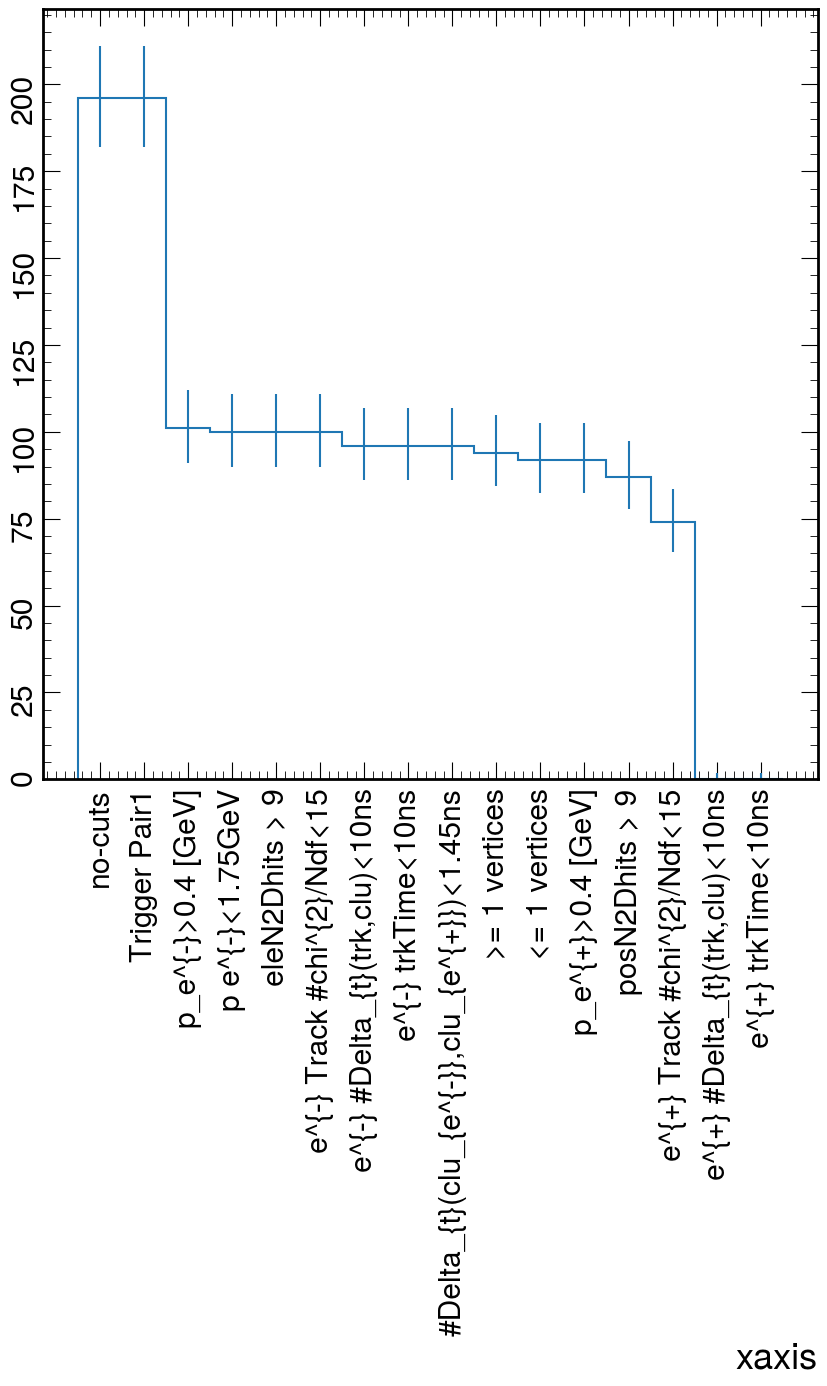

In [197]:
selection_cutflow.plot()
plt.tick_params(labelrotation=90)

(array([ 95.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   1.]),
 array([0.        , 0.22222222, 0.44444444, 0.66666667, 0.88888889,
        1.11111111, 1.33333333, 1.55555556, 1.77777778, 2.        ]),
 <BarContainer object of 9 artists>)

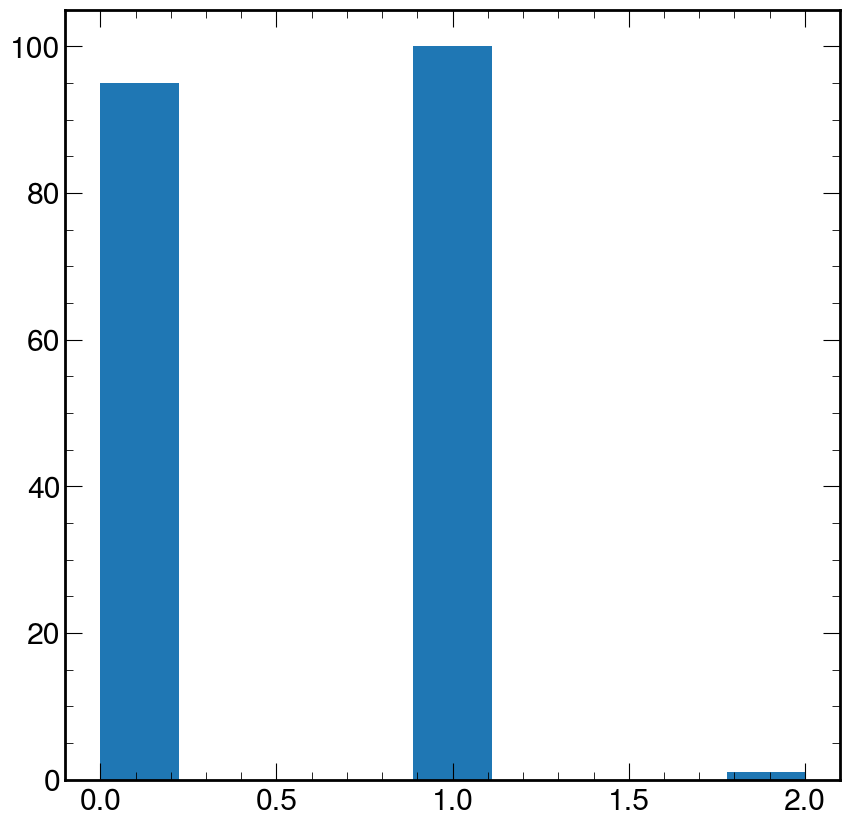

In [187]:
plt.hist(ak.count(reco_events['UnconstrainedV0Vertices_KF/UnconstrainedV0Vertices_KF.chi2_'], axis=1),bins='auto')

In [212]:
reco_events = coffea.nanoevents.NanoEventsFactory.from_root(
    'test.root', 'HPS_Event',
    schemaclass=coffea.nanoevents.BaseSchema,
    metadata={'dataset':'test'},
).events()

NotImplementedError: memberwise serialization of AsArray
in file test.root

In [157]:
reco_events['EventHeader/pair1_trigger_']

<Array [0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0] type='196 * int32[parameters=...'>

In [158]:
candidates = coffea.nanoevents.NanoEventsFactory.from_root(
    'test_ana.root', 'iDMCandidates',
    schemaclass=coffea.nanoevents.BaseSchema,
    metadata={'dataset':'test'},
).events()

KeyError: 'e9d48440-2a49-11ee-8e0e-4db45ea0beef:/iDMCandidates;1:vtx(1)/parts_(13)'

In [148]:
ak.zip({'reco':reco_events, 'candidates':candidates})

<Array [{reco: {...}, ...}, {...}, ..., {...}] type='196 * {reco: event, ca...'>

## Experimental Schema
Trying to play with `ak.zip` to make form of awkward arrays better.

In [213]:
f = uproot.open('test.root')

In [215]:
f['HPS_Event'].show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
EventHeader          | EventHeader              | AsGroup(<TBranchElement 'Ev...
EventHeader/TObject  | (group of fUniqueID:u... | AsGroup(<TBranchElement 'TO...
EventHeader/TObje... | uint32_t                 | AsDtype('>u4')
EventHeader/TObje... | uint32_t                 | AsDtype('>u4')
EventHeader/event... | int32_t                  | AsDtype('>i4')
EventHeader/event... | int64_t                  | AsDtype('>i8')
EventHeader/run_n... | int32_t                  | AsDtype('>i4')
EventHeader/pair0... | int32_t                  | AsDtype('>i4')
EventHeader/pair1... | int32_t                  | AsDtype('>i4')
EventHeader/pulse... | int32_t                  | AsDtype('>i4')
EventHeader/singl... | int32_t                  | AsDtype('>i4')
EventHeader/singl... | int32_t                  | AsDtype('>i4')
EventHeader/svt_b... | int

In [217]:
f['HPS_Event'].arrays(
    filter_name=['MCParticle/*', 'UnconstrainedV0Vertices_KF/*']
)

NotImplementedError: memberwise serialization of AsArray
in file test.root

In [41]:
for field in events.fields:
    if all([f.startswith(field) for f in events[field].fields]):
        events[field] = {
            f.strip(field+'.'): events[field][f]
            for f in events[field].fields
        }

In [42]:
events

<Array [{EventHeader: {...}, ...}, ..., {...}] type='196 * {EventHeader: {f...'>

In [30]:
import re
form = {}
for br in events.fields:
    sub_branches = re.split('[/.]', br)
    condensed_sub_branches = [
        b
        for i, b in enumerate(sub_branches)
        if i==0 or b != sub_branches[i-1]
    ]
    location = form.get(condensed_sub_branches[0], dict())
    form[condensed_sub_branches[0]] = location
    for b in condensed_sub_branches[1:-1]:
        sub = location.get(b, dict())
        location[b] = sub
        location = sub
    if condensed_sub_branches[-1] == 'parameters_':
        continue
    location[condensed_sub_branches[-1]] = events[br]

def recurzip(form):
    if isinstance(form, ak.Array):
        return form
    
    if all([isinstance(value, ak.Array) for value in form.values()]):
        print()
        print(form)
        return ak.zip(form)
    
    for field in form:
        form[field] = recurzip(form[field])
    
recurzip(form)


{'fUniqueID': <Array [0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0] type='196 * uint32[parameters...'>, 'fBits': <Array [50331648, 50331648, ..., 50331648] type='196 * uint32[parameters={"...'>}

{'fUniqueID': <Array [0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0] type='196 * uint32[parameters...'>, 'fBits': <Array [50331648, 50331648, ..., 50331648] type='196 * uint32[parameters={"...'>}

{'blocklevel': <Array [2576980377, ..., 2576980377] type='196 * uint32[parameters={"__doc_...'>, 'blocknum': <Array [2576980377, ..., 2576980377] type='196 * uint32[parameters={"__doc_...'>, 'nothing': <Array [2576980377, ..., 2576980377] type='196 * uint32[parameters={"__doc_...'>, 'slotid': <Array [2576980377, ..., 2576980377] type='196 * uint32[parameters={"__doc_...'>, 'type': <Array [2576980377, ..., 2576980377] type='196 * uint32[parameters={"__doc_...'>, 'istype': <Array [True, True, True, ..., True, True] type='196 * bool[parameters={"__...'>}

{'nwords': <Array [2576980377, ..., 2576980377] type='196 * uint

ValueError: cannot broadcast nested list